<a href="https://colab.research.google.com/github/spsagar13/Natural-Language-Processing/blob/main/IMDB_3_models_evaluation_GRU_LSTM_and_Conv1d.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
print(tf.__version__)

# !pip install -q tensorflow-datasets

2.4.1


In [ ]:
import tensorflow_datasets as tfds
imdb, info = tfds.load("imdb_reviews", with_info=True, as_supervised=True)


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteGCW24W/imdb_reviews-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteGCW24W/imdb_reviews-test.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteGCW24W/imdb_reviews-unsupervised.tfrecord


Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


In [ ]:
import numpy as np

train_data, test_data = imdb['train'], imdb['test']

training_sentences = []
training_labels = []

testing_sentences = []
testing_labels = []

# str(s.tonumpy()) is needed in Python3 instead of just s.numpy()
for s,l in train_data:
  training_sentences.append(str(s.numpy()))
  training_labels.append(l.numpy())
  
for s,l in test_data:
  testing_sentences.append(str(s.numpy()))
  testing_labels.append(l.numpy())
  
training_labels_final = np.array(training_labels)
testing_labels_final = np.array(testing_labels)


In [ ]:
vocab_size = 10000
embedding_dim = 16
max_length = 120
trunc_type='post'
oov_tok = "<OOV>"


from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index
sequences = tokenizer.texts_to_sequences(training_sentences)
padded = pad_sequences(sequences,maxlen=max_length, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences,maxlen=max_length)


In [ ]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

print(decode_review(padded[1]))
print(training_sentences[1])

? ? ? ? ? ? ? b'i have been known to fall asleep during films but this is usually due to a combination of things including really tired being warm and comfortable on the <OOV> and having just eaten a lot however on this occasion i fell asleep because the film was rubbish the plot development was constant constantly slow and boring things seemed to happen but with no explanation of what was causing them or why i admit i may have missed part of the film but i watched the majority of it and everything just seemed to happen of its own <OOV> without any real concern for anything else i cant recommend this film at all '
b'I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, being warm and comfortable on the sette and having just eaten a lot. However on this occasion I fell asleep because the film was rubbish. The plot development was constant. Constantly slow and boring. Things seemed to happen, but with no explanation of 

In [ ]:
# Model Definition with GRU
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(32)),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 120, 16)           160000    
_________________________________________________________________
bidirectional (Bidirectional (None, 64)                9600      
_________________________________________________________________
dense (Dense)                (None, 6)                 390       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 7         
Total params: 169,997
Trainable params: 169,997
Non-trainable params: 0
_________________________________________________________________


In [ ]:
num_epochs = 50
history = model.fit(padded, training_labels_final, epochs=num_epochs, validation_data=(testing_padded, testing_labels_final))

Epoch 1/50
782/782 [==============================] - 49s 19ms/step - loss: 0.6510 - accuracy: 0.5890 - val_loss: 0.3789 - val_accuracy: 0.8324
Epoch 2/50
782/782 [==============================] - 14s 18ms/step - loss: 0.3271 - accuracy: 0.8683 - val_loss: 0.3634 - val_accuracy: 0.8418
Epoch 3/50
782/782 [==============================] - 14s 18ms/step - loss: 0.2599 - accuracy: 0.9031 - val_loss: 0.3725 - val_accuracy: 0.8434
Epoch 4/50
782/782 [==============================] - 14s 18ms/step - loss: 0.2015 - accuracy: 0.9272 - val_loss: 0.4055 - val_accuracy: 0.8377
Epoch 5/50
782/782 [==============================] - 15s 19ms/step - loss: 0.1669 - accuracy: 0.9445 - val_loss: 0.4074 - val_accuracy: 0.8369
Epoch 6/50
782/782 [==============================] - 15s 19ms/step - loss: 0.1498 - accuracy: 0.9521 - val_loss: 0.5148 - val_accuracy: 0.8246
Epoch 7/50
782/782 [==============================] - 14s 18ms/step - loss: 0.1202 - accuracy: 0.9640 - val_loss: 0.4722 - val_accuracy:

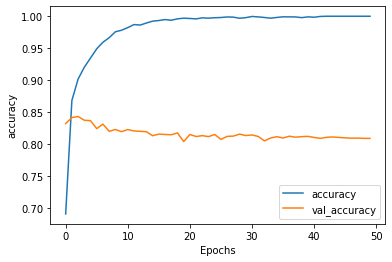

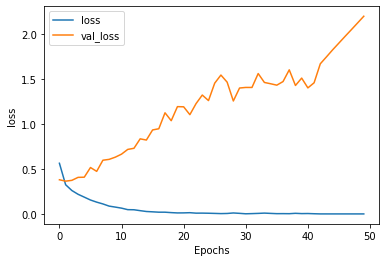

In [ ]:
import matplotlib.pyplot as plt

def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

In [ ]:
# Model Definition with LSTM
model_lstm = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model_lstm.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model_lstm.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 120, 16)           160000    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64)                12544     
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 390       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 7         
Total params: 172,941
Trainable params: 172,941
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history_lstm = model_lstm.fit(padded, training_labels_final, epochs=num_epochs, validation_data=(testing_padded, testing_labels_final))

Epoch 1/50
782/782 [==============================] - 18s 20ms/step - loss: 0.6046 - accuracy: 0.6355 - val_loss: 0.4133 - val_accuracy: 0.8219
Epoch 2/50
782/782 [==============================] - 15s 19ms/step - loss: 0.3169 - accuracy: 0.8717 - val_loss: 0.3515 - val_accuracy: 0.8457
Epoch 3/50
782/782 [==============================] - 14s 18ms/step - loss: 0.2288 - accuracy: 0.9119 - val_loss: 0.3711 - val_accuracy: 0.8384
Epoch 4/50
782/782 [==============================] - 15s 19ms/step - loss: 0.1916 - accuracy: 0.9328 - val_loss: 0.3930 - val_accuracy: 0.8381
Epoch 5/50
782/782 [==============================] - 15s 19ms/step - loss: 0.1469 - accuracy: 0.9510 - val_loss: 0.4468 - val_accuracy: 0.8336
Epoch 6/50
782/782 [==============================] - 14s 18ms/step - loss: 0.1083 - accuracy: 0.9658 - val_loss: 0.5465 - val_accuracy: 0.8170
Epoch 7/50
782/782 [==============================] - 14s 19ms/step - loss: 0.0861 - accuracy: 0.9712 - val_loss: 0.5909 - val_accuracy:

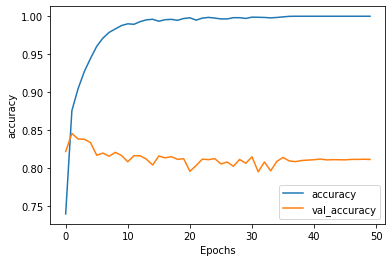

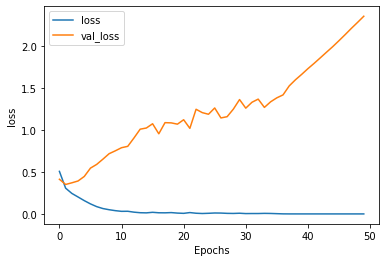

In [ ]:
plot_graphs(history_lstm, 'accuracy')
plot_graphs(history_lstm, 'loss')

In [ ]:
# Model Definition with Conv1D
model_conv = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Conv1D(128, 5, activation='relu'),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model_conv.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model_conv.summary()


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 120, 16)           160000    
_________________________________________________________________
conv1d (Conv1D)              (None, 116, 128)          10368     
_________________________________________________________________
global_average_pooling1d (Gl (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 6)                 774       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 7         
Total params: 171,149
Trainable params: 171,149
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history_conv = model_conv.fit(padded, training_labels_final, epochs=num_epochs, validation_data=(testing_padded, testing_labels_final))

Epoch 1/50
782/782 [==============================] - 7s 8ms/step - loss: 0.6003 - accuracy: 0.6733 - val_loss: 0.4360 - val_accuracy: 0.8428
Epoch 2/50
782/782 [==============================] - 6s 8ms/step - loss: 0.3702 - accuracy: 0.8841 - val_loss: 0.3994 - val_accuracy: 0.8420
Epoch 3/50
782/782 [==============================] - 6s 8ms/step - loss: 0.2876 - accuracy: 0.9109 - val_loss: 0.4191 - val_accuracy: 0.8350
Epoch 4/50
782/782 [==============================] - 6s 8ms/step - loss: 0.2247 - accuracy: 0.9340 - val_loss: 0.4495 - val_accuracy: 0.8300
Epoch 5/50
782/782 [==============================] - 6s 8ms/step - loss: 0.1920 - accuracy: 0.9456 - val_loss: 0.5432 - val_accuracy: 0.8276
Epoch 6/50
782/782 [==============================] - 6s 7ms/step - loss: 0.1570 - accuracy: 0.9564 - val_loss: 0.6240 - val_accuracy: 0.8224
Epoch 7/50
782/782 [==============================] - 6s 7ms/step - loss: 0.1443 - accuracy: 0.9611 - val_loss: 0.6639 - val_accuracy: 0.8191
Epoch 

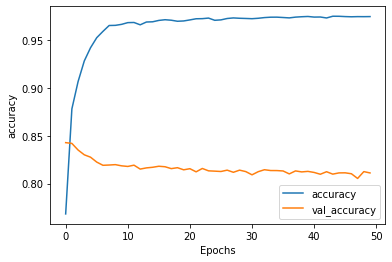

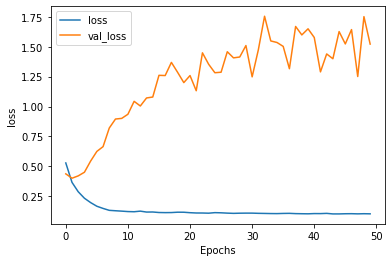

In [ ]:
plot_graphs(history_conv, 'accuracy')
plot_graphs(history_conv, 'loss')